In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# load data

In [11]:
dataset = pd.read_csv("ml-100k/u.data", sep="\t", names="user_id,item_id,rating,timestamp".split(","))

In [12]:
# assign a unique number(0,) to each user and each item

dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [13]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [14]:
# toy example though

len(dataset), len(dataset.user_id.unique()), len(dataset.item_id.unique())

(100000, 943, 1682)

# Train-test split

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

# Matrix factorization

In [16]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

In [17]:
movie_input = keras.layers.Input(shape=[1], name="Item")
movie_embedding = keras.layers.Embedding(n_movies+1, n_latent_factors, name="Movie-Embedding")(movie_input)
movie_vec = keras.layers.Flatten(name="FlattenMovies")(movie_embedding)

user_input = keras.layers.Input(shape=[1], name="User")
user_embedding = keras.layers.Embedding(n_users+1, n_latent_factors, name="User-Embedding")(user_input)
user_vec = keras.layers.Flatten(name="FlattenUsers")(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=1, name="DotProduct")
model = keras.Model([user_input, movie_input], prod)
model.compile("adam", "mean_squared_error")

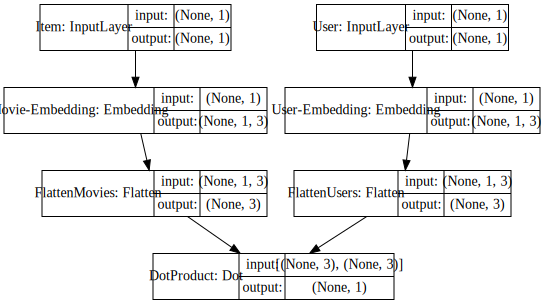

In [18]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir="HB").create(prog="dot", format="svg"))

In [19]:
hist = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


Text(0,0.5,'Train Error')

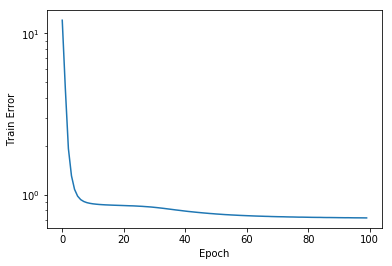

In [20]:
pd.Series(hist.history["loss"]).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [21]:
y_hat = np.round(model.predict([test.user_id, test.item_id]), 0)
y_true = test.rating

In [22]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.6959

# Pseudo-siamese network

In [24]:
n_latent_factors_users = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1], name="Item")
movie_embedding = keras.layers.Embedding(n_movies+1, n_latent_factors_movie, name="Movie-Embedding")(movie_input)
movie_vec = keras.layers.Flatten(name="FlattenMovies")(movie_embedding)

user_input = keras.layers.Input(shape=[1], name="User")
user_embedding = keras.layers.Embedding(n_users+1, n_latent_factors_users, name="User-Embedding")(user_input)
user_vec = keras.layers.Flatten(name="FlattenUsers")(user_embedding)

concat = keras.layers.merge.concatenate([movie_vec, user_vec], name="Concat")
dense_1 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dense_2 = keras.layers.Dense(50,name='FullyConnected-2')(dense_1)

result = keras.layers.Dense(1, activation="relu", name="Activation")(dense_2)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam, loss="mean_absolute_error")

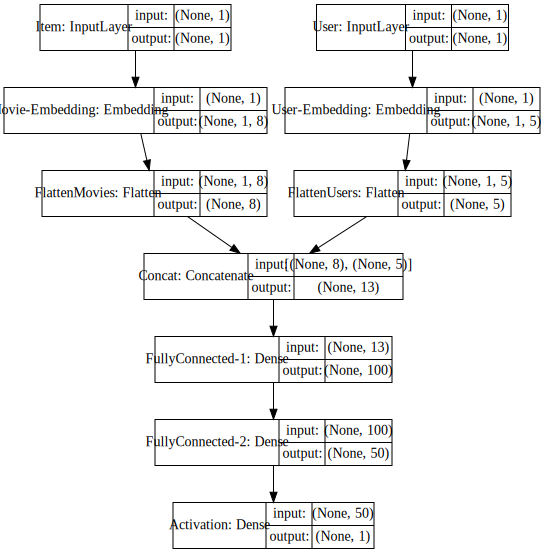

In [25]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir="HB").create(prog="dot", format="svg"))

In [26]:
hist = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

Text(0,0.5,'Train Error')

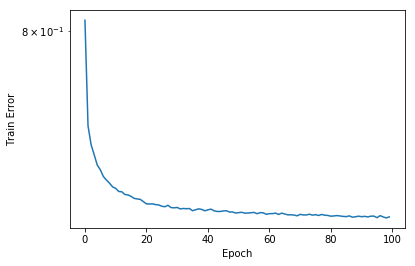

In [27]:
pd.Series(hist.history["loss"]).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [28]:
y_hat = np.round(model.predict([test.user_id, test.item_id]), 0)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

0.7133

# Simple SVD beats complex network without tuning in this case. However, as the number of input features increases, network still has a chance to win.